<a href="https://colab.research.google.com/github/cianyu12/Credit-risk-study/blob/main/Credit_Risk_Approval_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Credit Risk Model for improving approval process.

Data was collected by https://www.kaggle.com/datasets/laotse/credit-risk-dataset

# Library in used

In [1]:
#!pip install feature_engine
#!pip install catboost
#basic
import numpy as np
import pandas as pd
#plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

#sklearn and model
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import probplot
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from yellowbrick.classifier import ClassPredictionError

import warnings, gc
warnings.filterwarnings("ignore")

## Read data

In [2]:
path = '/content/sample_data/credit_risk_dataset.csv'
df = pd.read_csv(path)
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Drop the duplicate rows

In [3]:
df = df.drop_duplicates()

Check null values

In [4]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [5]:
df = df.dropna()
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [6]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

### Data Description

In [7]:
#Categorical variable

cat_cols = [col for col in df.columns if df[col].dtypes == 'O']

#Continuous variable

con_cols = [col for col in df.columns if df[col].dtypes != 'O']

cat_but_con = [col for col in df.columns if df[col].dtypes == 'O' and df[col].nunique() > 20]

con_but_cat = [col for col in df.columns if df[col].dtypes != 'O' and df[col].nunique() < 10]

print(f"Observation: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Categorical variable: {len(cat_cols)}")
print(f"Continuous variable: {len(con_cols)}")
print(f"Continuous variable but in string: {len(con_but_cat)}")
print(f"Categorical variable but in number: {len(cat_but_con)}")


Observation: 28501
Variables: 12
Categorical variable: 4
Continuous variable: 8
Continuous variable but in string: 1
Categorical variable but in number: 0


### Find Correlation for each variable

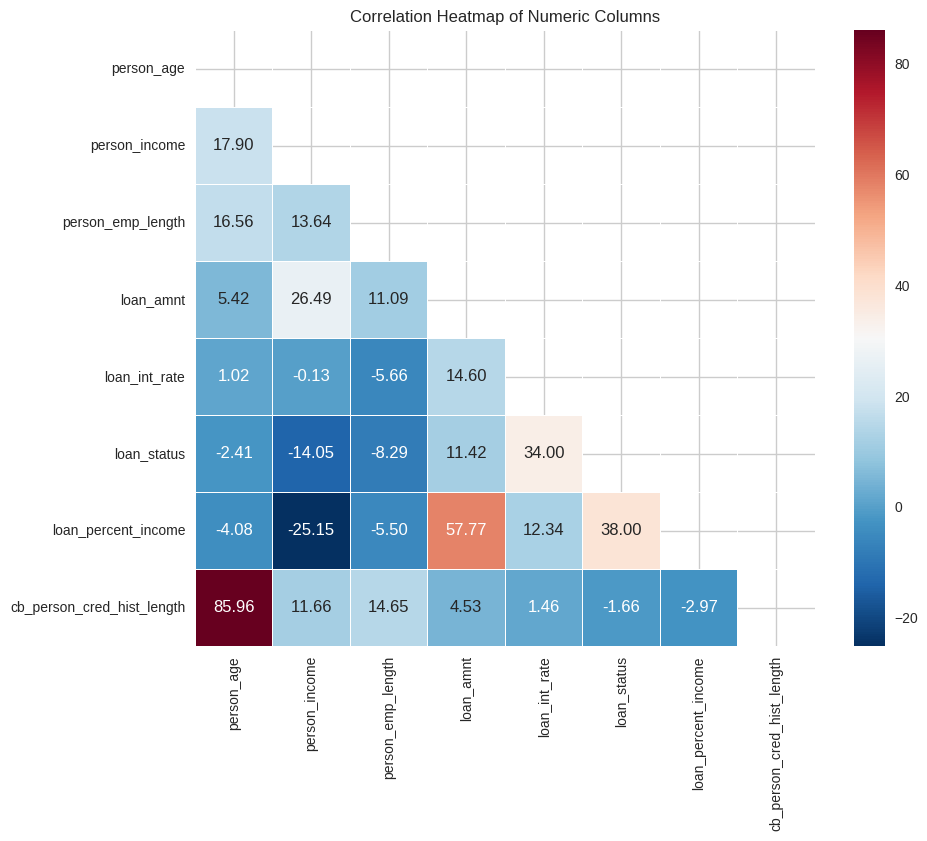

In [8]:
# Assuming your DataFrame is named 'df' and contains the specified columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_data = df[numeric_cols]

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a custom colormap for red-black tones
cmap = sns.color_palette("RdBu_r", as_cmap=True)

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix * 100, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()



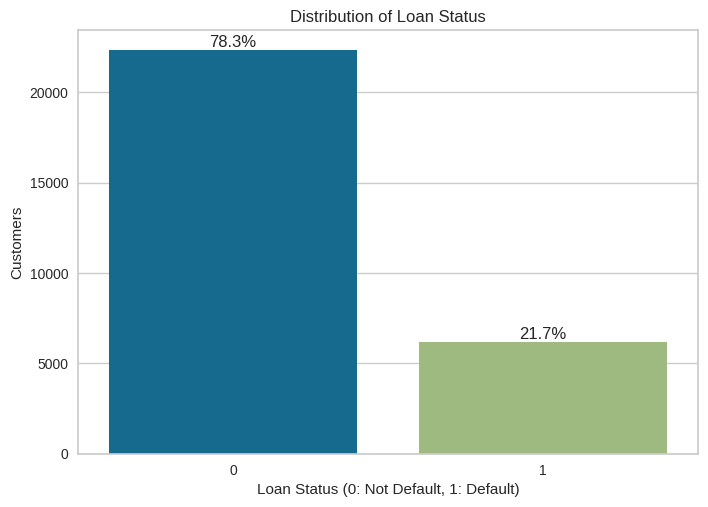

In [9]:
total_records = len(df)
ax = sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status (0: Not Default, 1: Default)')
plt.ylabel('Customers')

# Annotate with percentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_records)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()


## Data Cleaning

### Outlier

In [10]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in con_cols:
    if col != "loan_status":
      print(col, check_outlier(df, col))

person_age True
person_income True
person_emp_length True
loan_amnt False
loan_int_rate False
loan_percent_income True
cb_person_cred_hist_length True


Then We will fix the loan_amnt and loan_int_rate with low and up limit to delete outlier.

In [11]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in con_cols:
    if col != "loan_status":
        replace_with_thresholds(df,col)

## Feature Engineering

### Age

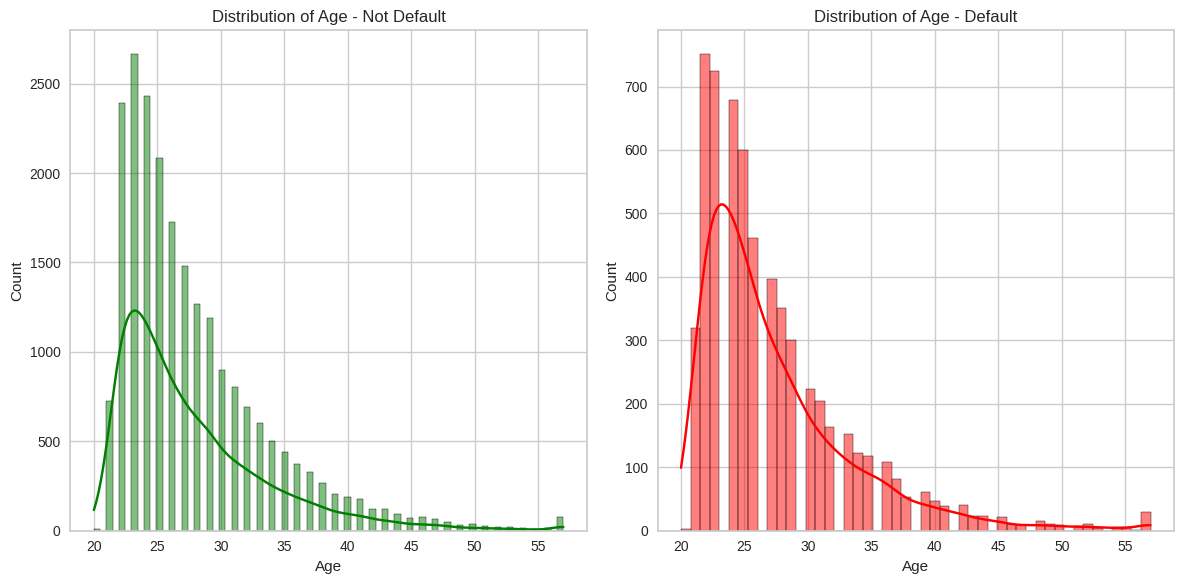

In [12]:
plt.figure(figsize=(12, 6))

# Plot for loan_status 0 (Not Default)
plt.subplot(1, 2, 1)
sns.histplot(df[df['loan_status'] == 0]['person_age'], kde=True, color='green')
plt.title('Distribution of Age - Not Default')
plt.xlabel('Age')
plt.ylabel('Count')

# Plot for loan_status 1 (Default)
plt.subplot(1, 2, 2)
sns.histplot(df[df['loan_status'] == 1]['person_age'], kde=True, color='red')
plt.title('Distribution of Age - Default')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


The distribution of Age for each loan status are the same.

### House Ownership

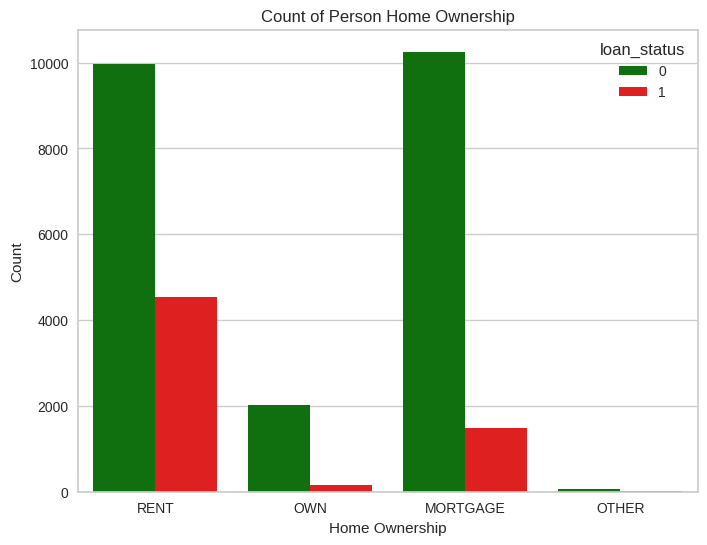

In [13]:
# Assuming your DataFrame is named 'df'
plt.figure(figsize=(8, 6))

custom_palette = {0: 'green', 1: 'red'}

# Count plot for person_home_ownership
sns.countplot(x='person_home_ownership',hue = 'loan_status',data=df,palette = custom_palette)

plt.title('Count of Person Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()


The high percentage of default came from rent and mortage type.

### Loan Grade

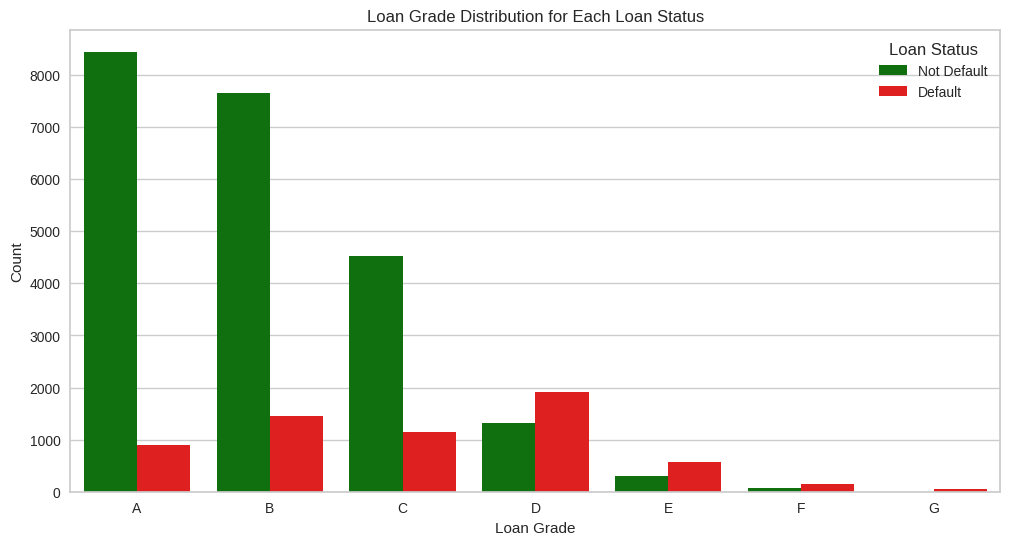

In [14]:
plt.figure(figsize=(12, 6))

# Custom colors: red for loan_status = 1 (Default), green for loan_status = 0 (Not Default)
custom_palette = {0: 'green', 1: 'red'}

# Order of loan_grade from A to Z
grade_order = sorted(df['loan_grade'].unique())

# Grouped bar chart for loan_grade and loan_status with custom colors and sorted order
sns.countplot(x='loan_grade', hue='loan_status', data=df, palette=custom_palette, order=grade_order)

plt.title('Loan Grade Distribution for Each Loan Status')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status', labels=['Not Default', 'Default'])
plt.show()

The loan grade from D-G show a high default.

### Loan intent

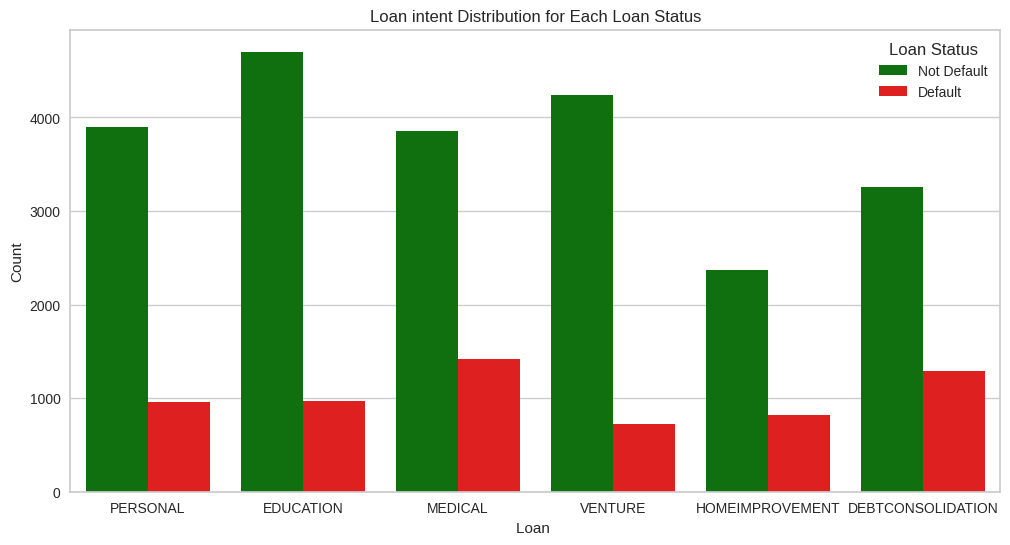

In [15]:
plt.figure(figsize=(12, 6))

# Custom colors: red for loan_status = 1 (Default), green for loan_status = 0 (Not Default)
custom_palette = {0: 'green', 1: 'red'}

# Order of loan_grade from A to Z

# Grouped bar chart for loan_grade and loan_status with custom colors and sorted order
sns.countplot(x='loan_intent', hue='loan_status', data=df, palette=custom_palette)

plt.title('Loan intent Distribution for Each Loan Status')
plt.xlabel('Loan ')
plt.ylabel('Count')
plt.legend(title='Loan Status', labels=['Not Default', 'Default'])
plt.show()

In [16]:
def plot_distribution(df, column):
    plt.figure(figsize=(10, 6))

    # Custom colors: red for loan_status = 1 (Default), green for loan_status = 0 (Not Default)
    custom_palette = {0: 'green', 1: 'red'}

    # Plot KDE for each loan status
    for status in [0, 1]:
        subset = df[df['loan_status'] == status]
        sns.kdeplot(subset[column], label=f'Loan Status {status}', color=custom_palette[status], fill=True)

    plt.title(f'Kernel Density Estimate of {column} for Each Loan Status')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [17]:
### Loan Amount

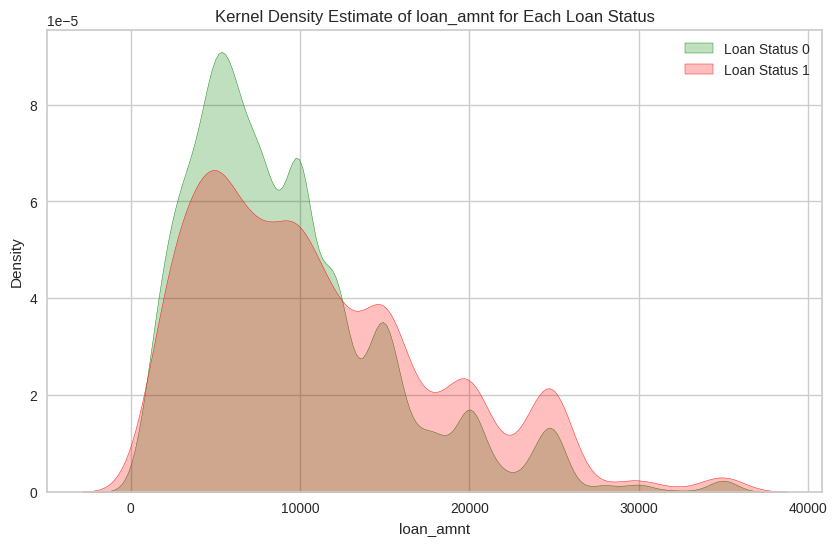

In [18]:
plot_distribution(df,'loan_amnt')

### Person_income

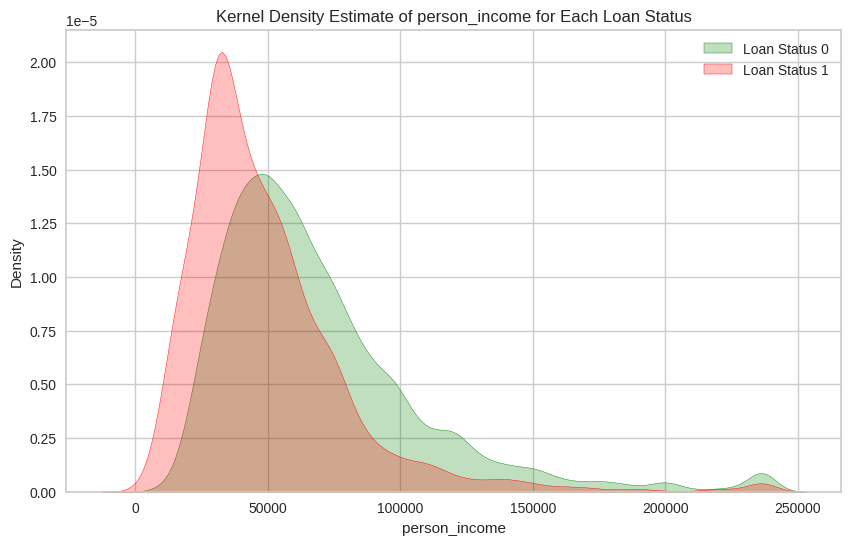

In [19]:
plot_distribution(df,'person_income')

### Loan interest rate

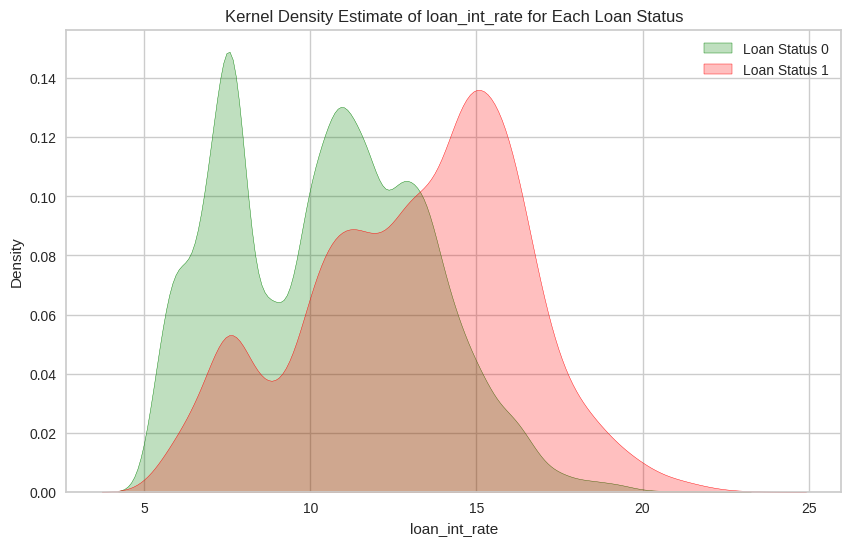

In [20]:
plot_distribution(df,'loan_int_rate')

### Person employee Legnth

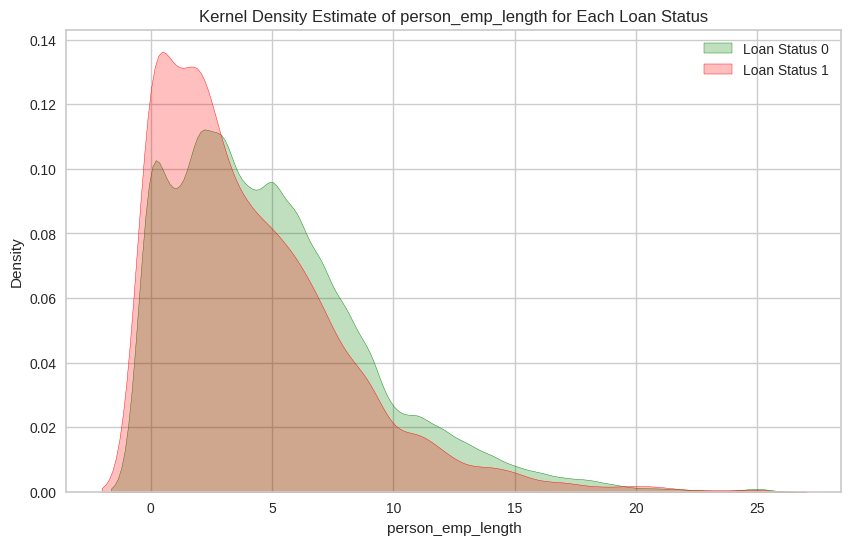

In [21]:
plot_distribution(df,'person_emp_length')

In [22]:
df['income_interval'] = pd.cut(df['person_income'],
                                                        bins=5,
                                                        labels=['low', 'low-middle', 'middle', 'high-middle', 'high'])

## CB cb_person_cred_hist_length

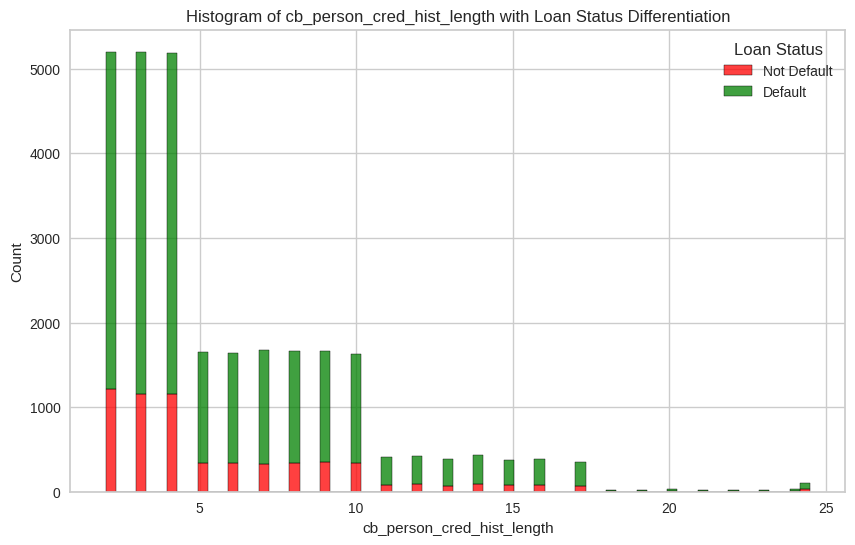

In [33]:
plt.figure(figsize=(10, 6))

# Plot histogram with color differentiation for loan_status
sns.histplot(data=df, x='cb_person_cred_hist_length', hue='loan_status', bins='auto', multiple='stack', palette={0: 'green', 1: 'red'})

plt.title('Histogram of cb_person_cred_hist_length with Loan Status Differentiation')
plt.xlabel('cb_person_cred_hist_length')
plt.ylabel('Count')
plt.legend(title='Loan Status', labels=['Not Default', 'Default'])
plt.show()


## Feature engineering and pre-processing data

Regarding to the distribution of Age is the same for both loan status so we cut it off.

In [38]:
type(cat_cols)

list

In [39]:
#Feature
df_feature = df.copy()

categorical_cols = cat_cols.append('income_interval')

df_feature = pd.get_dummies(df_feature, columns=categorical_cols, drop_first=True,dtype=int)
# Display the resulting DataFrame
print(df_feature.head())

   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          22          59000               25.0      35000          16.02   
1          21           9600                5.0       1000          11.14   
2          25           9600                1.0       5500          12.87   
3          23          65500                4.0      35000          15.23   
4          24          54400                8.0      35000          14.27   

   loan_status  loan_percent_income  cb_person_cred_hist_length  \
0            1                 0.59                         3.0   
1            0                 0.10                         2.0   
2            1                 0.57                         3.0   
3            1                 0.53                         2.0   
4            1                 0.55                         4.0   

   person_home_ownership_OTHER  person_home_ownership_OWN  ...  loan_grade_C  \
0                            0                        

In [40]:
df_feature.shape

(28501, 27)

In [41]:
#Feature
X = df_feature.drop(['loan_status','person_age','person_income'],axis=1)
#Target variable
Y = df_feature['loan_status']

## ML part

In [42]:
#Create Pipeline
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X = pipeline.fit_transform(X)
X.shape

(28501, 24)

In [43]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42,stratify=Y)
#scaling variables
scaler = StandardScaler()
#scaler= RobustScaler()
scaled_train_X = scaler.fit_transform(X_train)
scaled_test_X = scaler.transform(X_test)

In [61]:
#ROC curve
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_test,y_pred):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [62]:
import re
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

def train_and_evaluate_model(model):
    model.fit(scaled_train_X,y_train)
    y_pred = model.predict(scaled_test_X)
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print('-'*50)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    plot_roc_curve(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')
    roc_auc = roc_auc_score(y_test,y_pred,average='macro')

    if re.search('catboost',str(model)) == None:
        visualizer = ClassPredictionError(model)
        visualizer.score(scaled_test_X,y_test)
        visualizer.show()
        del visualizer

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)
    del acc, precision, recall, f1, roc_auc
    gc.collect()

### CatBoost Model

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4463
           1       0.96      0.70      0.81      1238

    accuracy                           0.93      5701
   macro avg       0.94      0.85      0.88      5701
weighted avg       0.93      0.93      0.92      5701

--------------------------------------------------


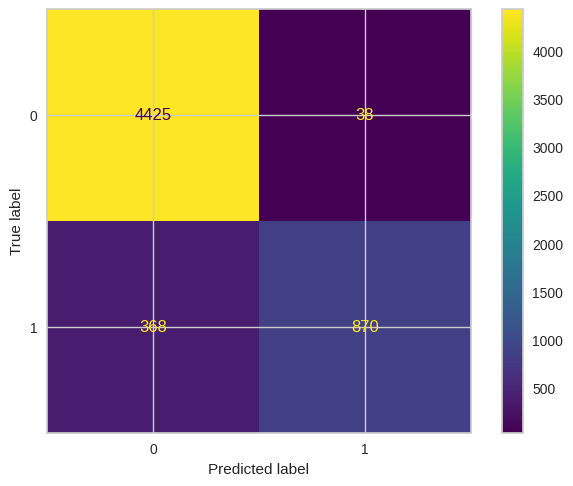

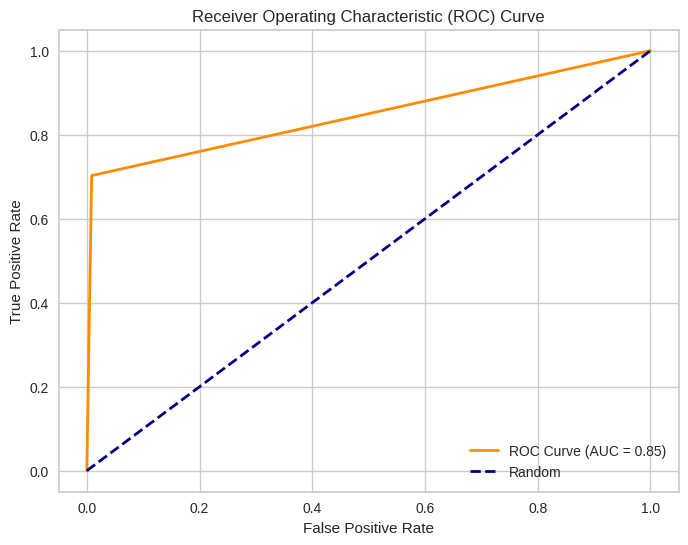

In [63]:
train_and_evaluate_model(CatBoostClassifier(silent=True))

### Light GBM

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4463
           1       0.96      0.70      0.81      1238

    accuracy                           0.93      5701
   macro avg       0.94      0.84      0.88      5701
weighted avg       0.93      0.93      0.92      5701

--------------------------------------------------


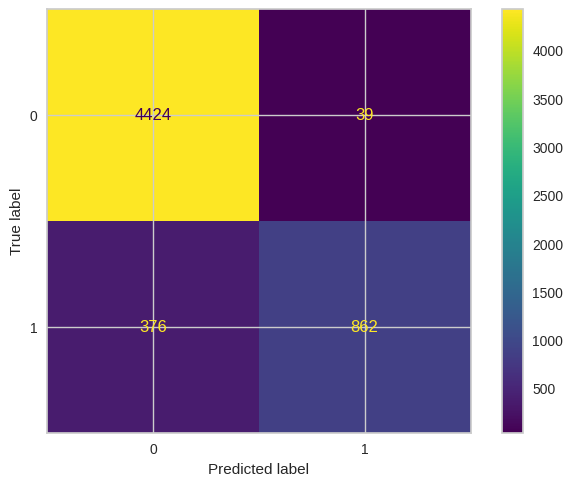

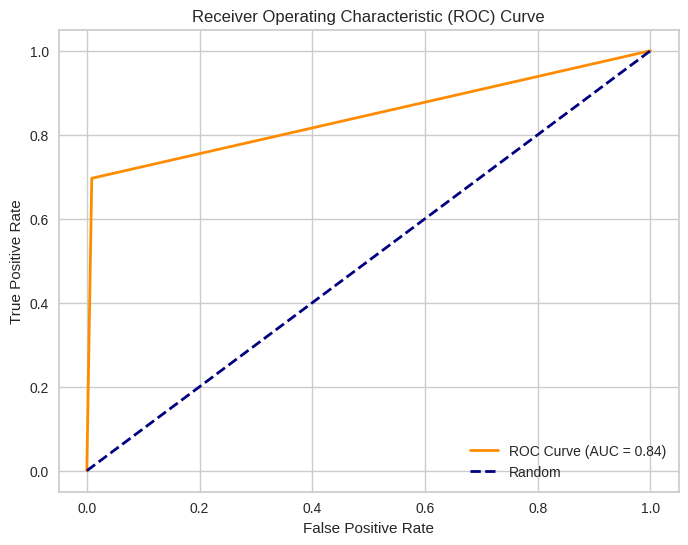

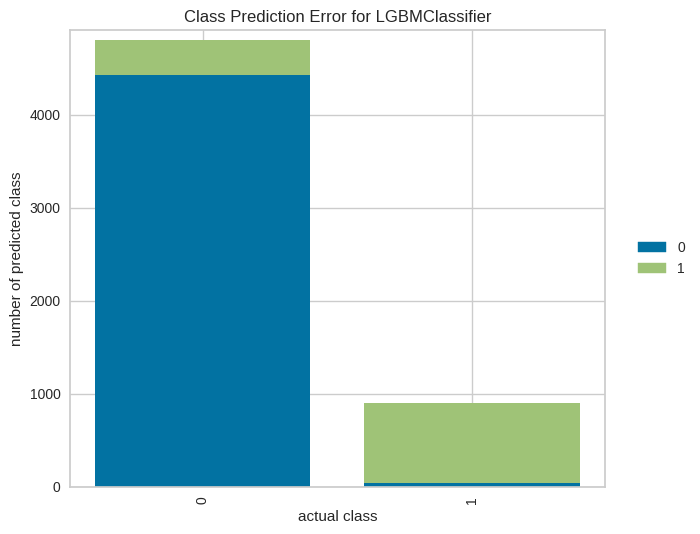

In [64]:
#Setting verbose=-1 means that the algorithm will operate silently without printing any progress or information to the console
train_and_evaluate_model(LGBMClassifier(verbose=-1))

### Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4463
           1       0.93      0.68      0.78      1238

    accuracy                           0.92      5701
   macro avg       0.92      0.83      0.87      5701
weighted avg       0.92      0.92      0.91      5701

--------------------------------------------------


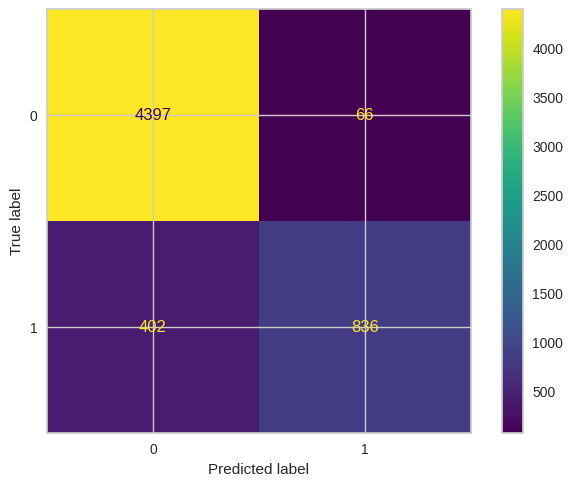

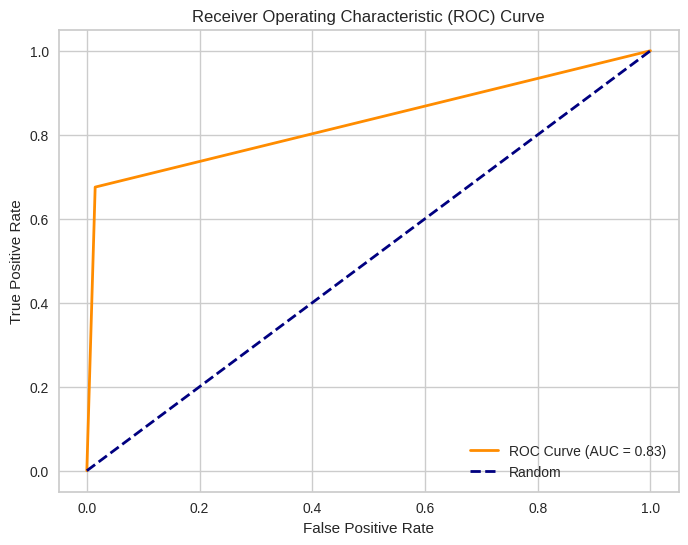

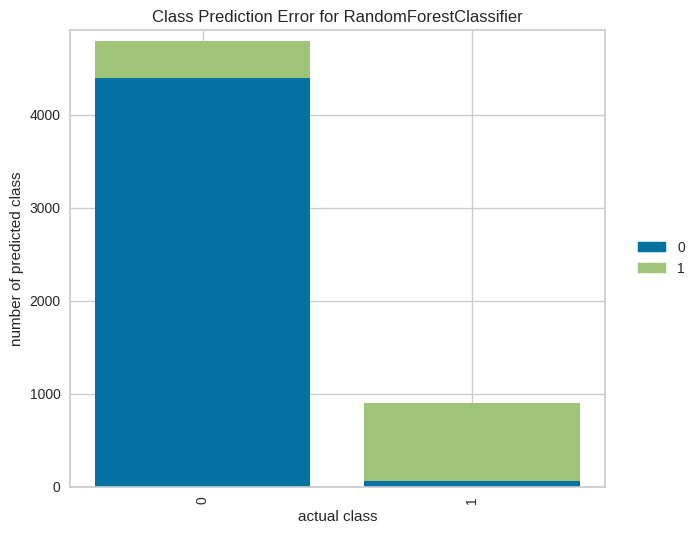

In [65]:
from sklearn.ensemble import RandomForestClassifier
train_and_evaluate_model(RandomForestClassifier())

### XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4463
           1       0.94      0.70      0.80      1238

    accuracy                           0.93      5701
   macro avg       0.93      0.84      0.88      5701
weighted avg       0.93      0.93      0.92      5701

--------------------------------------------------


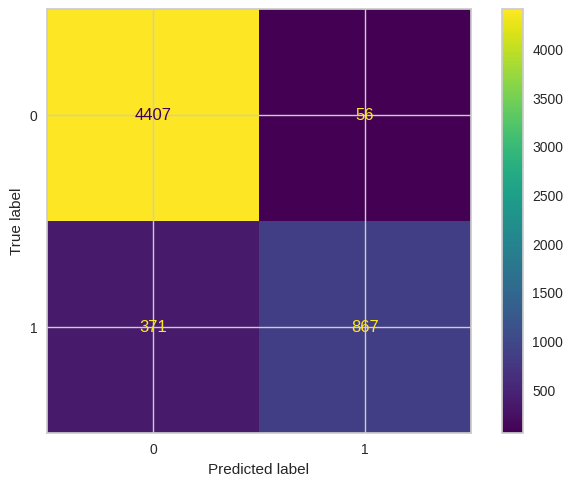

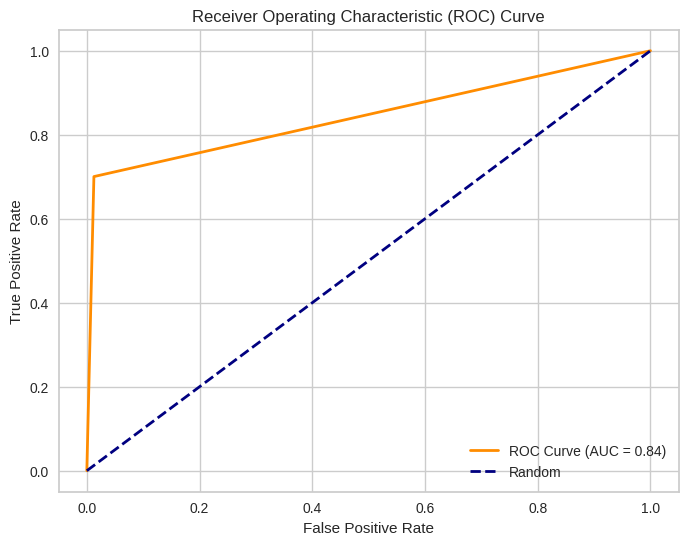

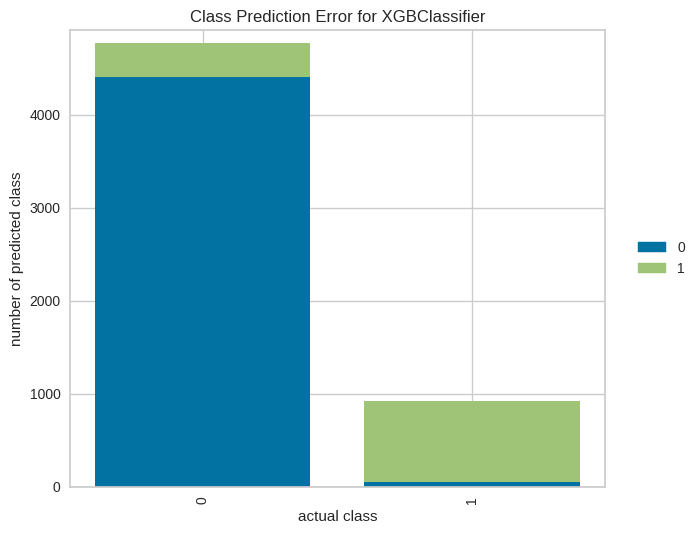

In [66]:
train_and_evaluate_model(XGBClassifier())

## Model Evaluation

In [72]:
model_performance = pd.DataFrame({'Model': models,
                            'Accuracy': accuracy_scores,
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_performance['Model'] = ['CatBoost','LGBM','XGboost','Randomforest']

In [73]:
model_performance

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,CatBoost,0.928784,0.940686,0.847116,0.883474,0.847116
1,LGBM,0.927206,0.939191,0.843773,0.880591,0.843773
2,XGboost,0.925101,0.930840,0.843888,0.878100,0.843888
3,Randomforest,0.917909,0.921531,0.830247,0.865390,0.830247


## Feature importance

In [81]:
Catmodel = CatBoostClassifier(silent=True)
Catmodel.fit(X,Y)

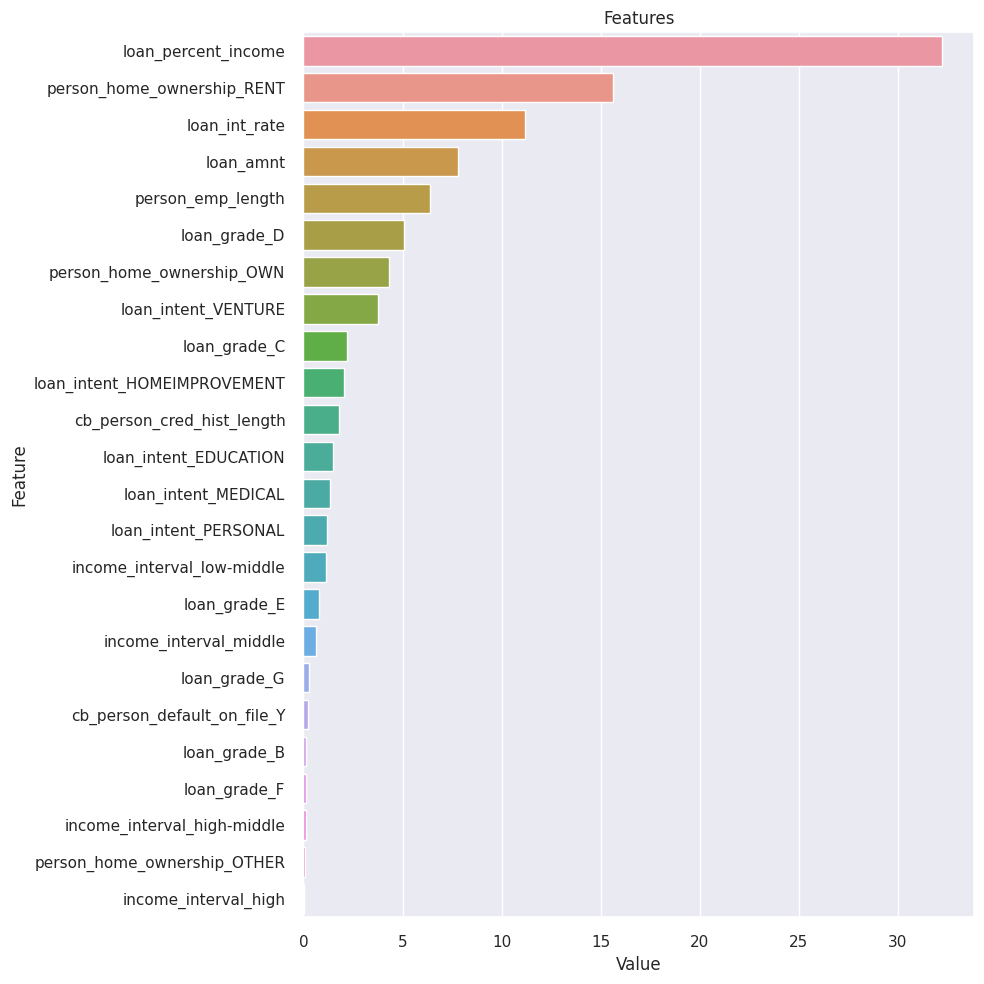

In [83]:
feature_imp = pd.DataFrame({"Value": Catmodel.feature_importances_, "Feature": X.columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:len(X)])
plt.title("Features")
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     22313
           1       0.99      0.74      0.85      6188

    accuracy                           0.94     28501
   macro avg       0.96      0.87      0.91     28501
weighted avg       0.95      0.94      0.94     28501

--------------------------------------------------


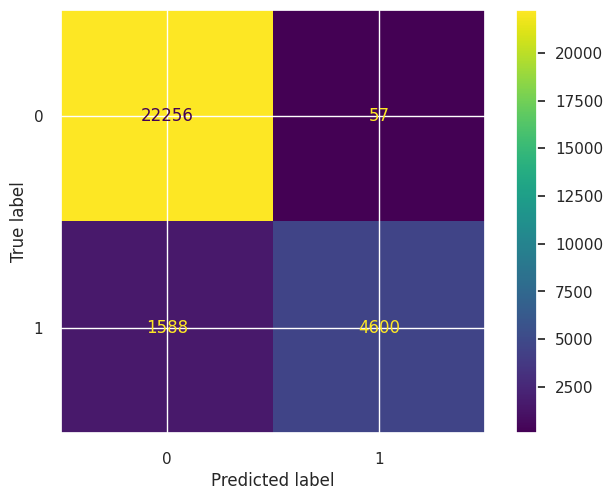

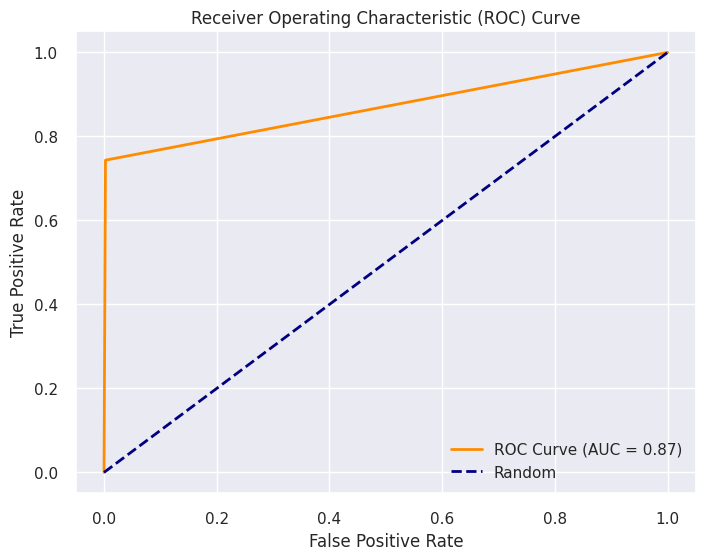

In [84]:
y_pred = Catmodel.predict(X)
print("Classification Report:")
print(classification_report(Y,y_pred))
print('-'*50)
ConfusionMatrixDisplay.from_predictions(Y,y_pred)
plot_roc_curve(Y,y_pred)